<a href="https://colab.research.google.com/github/Makxxx/DataMining_and_MachineLearning/blob/master/CEFR_with_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basic stuff

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline


from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

In [ ]:
data = pd.read_csv("https://raw.githubusercontent.com/Makxxx/data_dmmlProject/main/training_data.csv", index_col=0, dtype=str)
data.sentence = data.sentence.apply(lambda s: s.replace("'", ' '))
labels = data.difficulty.unique()
num_labels = len(labels)
data.difficulty = LabelEncoder().fit_transform(data.difficulty)

In [ ]:
data

,sentence,difficulty
id,,
0,Les coûts kilométriques réels peuvent diverger...,4
1,"Le bleu, c est ma couleur préférée mais je n a...",0
2,Le test de niveau en français est sur le site ...,0
3,Est-ce que ton mari est aussi de Boston?,0
4,"Dans les écoles de commerce, dans les couloirs...",2
...,...,...
4795,"C est pourquoi, il décida de remplacer les hab...",3
4796,Il avait une de ces pâleurs splendides qui don...,4
4797,"Et le premier samedi de chaque mois, venez ren...",1


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data.sentence, data.difficulty, test_size=0.2)

In [ ]:
from nltk.corpus import stopwords

def create_and_train_pipeline(clf, X_train, y_train, params={}):
    pipe = Pipeline([
            ('vect', CountVectorizer()),
            ('tfidf', TfidfTransformer()),
            ('clf', clf(**params)),
        ])

    pipe.fit(X_train, y_train)
    return pipe

lr_clf = create_and_train_pipeline(LogisticRegression, X_train, y_train)
knn_clf = create_and_train_pipeline(KNeighborsClassifier, X_train, y_train)
dt_clf = create_and_train_pipeline(DecisionTreeClassifier, X_train, y_train)
rf_clf = create_and_train_pipeline(RandomForestClassifier, X_train, y_train)
xgb_clf = create_and_train_pipeline(XGBClassifier, X_train, y_train)

In [ ]:
def evaluate_clf(clf, X_test, y_test, full=False):
    predicted = clf.predict(X_test)
    if full:
        return classification_report(y_test, predicted, target_names=labels)
    else:
        return np.mean(y_test == predicted)

In [ ]:
print("logistic", evaluate_clf(lr_clf, X_test, y_test))
print("knn", evaluate_clf(knn_clf, X_test, y_test))
print("dt", evaluate_clf(dt_clf, X_test, y_test))
print("rf", evaluate_clf(rf_clf, X_test, y_test))
print("xgb", evaluate_clf(xgb_clf, X_test, y_test))

logistic 0.4427083333333333
knn 0.33125
dt 0.32916666666666666
rf 0.384375
xgb 0.38333333333333336


# Real stuff

In [ ]:
!pip install transformers plotly==5.8.0 pyyaml==5.4.1 datasets pytorch-lightning > /dev/null 2>&1

In [ ]:
from pprint import pprint
import functools

import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
import pytorch_lightning as pl
from transformers import AutoModelForSequenceClassification, CamembertForMaskedLM, AutoTokenizer, AutoConfig
from datasets import load_dataset
from sklearn.metrics import confusion_matrix, f1_score

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from tqdm.notebook import tqdm

In [ ]:
camembert = CamembertForMaskedLM.from_pretrained('camembert-base')

Downloading:   0%|          | 0.00/508 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/445M [00:00<?, ?B/s]

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('camembert-base')

Downloading:   0%|          | 0.00/811k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

In [ ]:
def take_first_embedding(embeddings, attention_mask=None):
    return embeddings[:, 0]

def average_embeddings(embeddings, attention_mask):
    return (attention_mask[..., None] * embeddings).mean(1)

In [ ]:
dataset = load_dataset('vekkt/french_CEFR')
dataset

  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['sentence', 'difficulty', 'label'],
        num_rows: 3360
    })
    test: Dataset({
        features: ['sentence', 'difficulty', 'label'],
        num_rows: 960
    })
    validation: Dataset({
        features: ['sentence', 'difficulty', 'label'],
        num_rows: 480
    })
})

In [ ]:
pd_dataset = {split_name: split_data.to_pandas() for split_name, split_data in dataset.items()}
pd_dataset["validation"]

,sentence,difficulty,label
0,Êtes-vous pour ou contre la création d'un lexi...,C1,4
1,La loi sur laquelle s'est appuyé le gouverneme...,C1,4
2,"Eux, par contre, ont dû régler leur réveil",B2,3
3,Prends un pot de yaourt en verre.,A1,0
4,"En se retournant, Henry pouvait voir leurs lan...",C2,5
...,...,...,...
475,"Et comme elle était, à ses débuts, utilisée su...",B2,3
476,"Ses cheveux, dont les deux bandeaux noirs semb...",C2,5
477,Je retourne à mon vice !,A2,1
478,"Nos vignerons ont pris des claques, ont été hu...",B2,3


Le dataset comprend 6 labels.


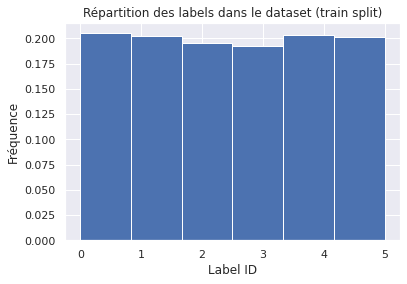

In [ ]:
sns.set_theme()

nb_labels = len(pd_dataset["train"]["label"].unique())
print(f"Le dataset comprend {nb_labels} labels.")

ax = pd_dataset["train"]["label"].hist(density=True, bins=nb_labels)
ax.set_xlabel("Label ID")
ax.set_ylabel("Fréquence")
ax.set_title("Répartition des labels dans le dataset (train split)")
ax.figure.show()

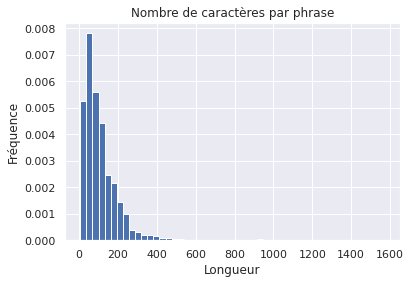

In [ ]:
pd_dataset["train"]["len_sen"] = pd_dataset["train"]["sentence"].apply(lambda x: len(x))
ax = pd_dataset["train"]["len_sen"].hist(density=True, bins=50)
ax.set_xlabel("Longueur")
ax.set_ylabel("Fréquence")
ax.set_title("Nombre de caractères par phrase")
ax.figure.show()

In [ ]:
pd_dataset["train"]["len_sen"].max()

1572

In [ ]:
from sklearn.preprocessing import LabelEncoder

def tokenize_batch(samples, tokenizer):
    text = [sample["sentence"] for sample in samples]
    labels = torch.tensor([sample["label"] for sample in samples])
    str_labels = [sample["difficulty"] for sample in samples]
    # The tokenizer handles
    # - Tokenization (amazing right?)
    # - Padding (adding empty tokens so that each example has the same length)
    # - Truncation (cutting samples that are too long)
    # - Special tokens (in CamemBERT, each sentence ends with a special token </s>)
    # - Attention mask (a binary vector which tells the model which tokens to look at. For instance it will not compute anything if the token is a padding token)
    tokens = tokenizer(text, padding="longest", return_tensors="pt")

    return {"input_ids": tokens.input_ids, "attention_mask": tokens.attention_mask, "labels": labels, "str_labels": str_labels, "sentences": text}

In [ ]:
train_dataset, val_dataset, test_dataset = dataset.values()

In [ ]:
num_labels = len(pd_dataset["train"]["label"].unique())

Il est important, surtout avec de petits jeux de données, que le modèle ne voit pas les données dans le même ordre. Pour éviter cela, on utilise l'argument `shuffle` du DataLoader.

In [ ]:
train_dataloader = DataLoader(
    dataset["train"], 
    batch_size=16, 
    shuffle=True, 
    collate_fn=functools.partial(tokenize_batch, tokenizer=tokenizer)
)
val_dataloader = DataLoader(
    dataset["validation"], 
    batch_size=16, 
    shuffle=False, 
    collate_fn=functools.partial(tokenize_batch, tokenizer=tokenizer)
)
test_dataloader = DataLoader(
    dataset["test"], 
    batch_size=16, 
    shuffle=False, 
    collate_fn=functools.partial(tokenize_batch, tokenizer=tokenizer)
)

In [ ]:
class LightningModel(pl.LightningModule):
    def __init__(self, model_name, num_labels, lr, weight_decay, from_scratch=False):
        super().__init__()
        self.save_hyperparameters()
        if from_scratch:
            # Si `from_scratch` est vrai, on charge uniquement la config (nombre de couches, hidden size, etc.) et pas les poids du modèle 
            config = AutoConfig.from_pretrained(
                model_name, num_labels=num_labels
            )
            self.model = AutoModelForSequenceClassification.from_config(config)
        else:
            # Cette méthode permet de télécharger le bon modèle pré-entraîné directement depuis le Hub de HuggingFace sur lequel sont stockés de nombreux modèles
            self.model = AutoModelForSequenceClassification.from_pretrained(
                model_name, num_labels=num_labels
            )
        self.lr = lr
        self.weight_decay = weight_decay
        self.num_labels = self.model.num_labels

    def forward(self, batch):
        return self.model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"]
        )

    def training_step(self, batch):
        out = self.forward(batch)

        logits = out.logits
        # -------- MASKED --------
        loss_fn = torch.nn.CrossEntropyLoss()
        loss = loss_fn(logits.view(-1, self.num_labels), batch["labels"].view(-1))

        # ------ END MASKED ------

        self.log("train/loss", loss)

        return loss

    def validation_step(self, batch, batch_index):
        labels = batch["labels"]
        out = self.forward(batch)

        preds = torch.max(out.logits, -1).indices
        # -------- MASKED --------
        acc = (batch["labels"] == preds).float().mean()
        # ------ END MASKED ------
        self.log("valid/acc", acc)

        f1 = f1_score(batch["labels"].cpu().tolist(), preds.cpu().tolist(), average="macro")
        self.log("valid/f1", f1)

    def predict_step(self, batch, batch_idx):
        """La fonction predict step facilite la prédiction de données. Elle est 
        similaire à `validation_step`, sans le calcul des métriques.
        """
        out = self.forward(batch)

        return torch.max(out.logits, -1).indices

    def configure_optimizers(self):
        return torch.optim.AdamW(
            self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay
        )

In [ ]:
lightning_model = LightningModel("camembert-base", num_labels, lr=5e-6, weight_decay=0.1)

model_checkpoint = pl.callbacks.ModelCheckpoint(monitor="valid/acc", mode="max")

camembert_trainer = pl.Trainer(
    max_epochs=50,
    gpus=1,
    callbacks=[
        pl.callbacks.EarlyStopping(monitor="valid/acc", patience=4, mode="max"),
        model_checkpoint,
    ]
)

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 

In [ ]:
# from ray.tune.integration.pytorch_lightning import TuneReportCallback, TuneReportCheckpointCallback
# from ray import tune

def train_cefr(config):
  lightning_model = LightningModel("camembert-base", num_labels, lr=config["lr"], weight_decay=config["wd"])
  # tune_callback = TuneReportCallback({
  #                   "loss": "ptl/val_loss",
  #                   "mean_accuracy": "ptl/val_accuracy"},
  #                   on="validation_end"),

  camembert_trainer = pl.Trainer(
      max_epochs=50,
      gpus=1,
      callbacks=[
          pl.callbacks.EarlyStopping(monitor="valid/acc", patience=4, mode="max"),
          model_checkpoint,
          # tune_callback
      ]
  )

  camembert_trainer.fit(lightning_model, train_dataloaders=train_dataloader, val_dataloaders=test_dataloader)


In [ ]:
config = {
    "lr": 5e-5,
    "wd": 1,
}

train_cefr(config)

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/data.py:85: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 16. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
lightning_model = LightningModel.load_from_checkpoint(checkpoint_path=model_checkpoint.best_model_path)

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 

In [ ]:
ID_TO_LABEL = dict(zip(range(6), ('A1', 'A2', 'B1', 'B2', 'C1', 'C2',)))
label_names = list(ID_TO_LABEL.values())

In [ ]:
def plot_confusion_matrix(labels, preds, label_names):
    confusion_norm = confusion_matrix(labels, preds.tolist(), labels=list(range(len(label_names))), normalize="true")
    confusion = confusion_matrix(labels, preds.tolist(), labels=list(range(len(label_names))))
    
    plt.figure(figsize=(16, 14))
    sns.heatmap(
        confusion_norm,
        annot=confusion,
        cbar=False,
        fmt="d",
        xticklabels=label_names,
        yticklabels=label_names,
        cmap="viridis"
    )

In [ ]:
camembert_preds = camembert_trainer.predict(lightning_model, dataloaders=val_dataloader)
camembert_preds = torch.cat(camembert_preds, -1)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

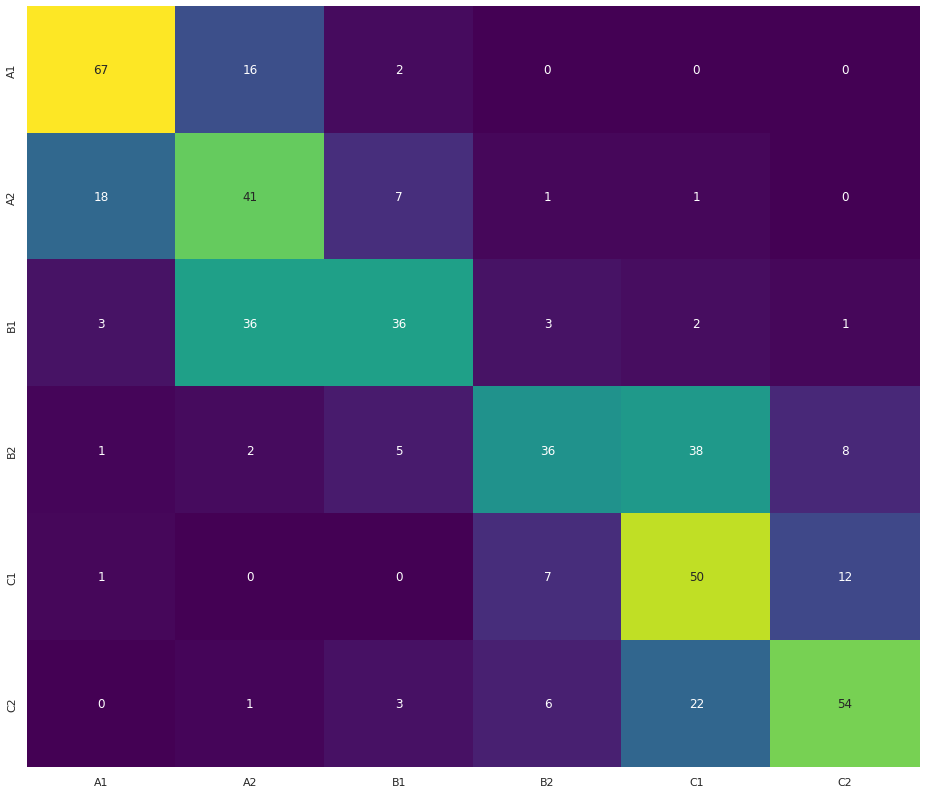

In [ ]:
plot_confusion_matrix(dataset["validation"]["label"], camembert_preds, label_names)

In [ ]:
print(classification_report(dataset["validation"]["label"], camembert_preds, target_names=label_names))

              precision    recall  f1-score   support

          A1       0.74      0.79      0.77        85
          A2       0.43      0.60      0.50        68
          B1       0.68      0.44      0.54        81
          B2       0.68      0.40      0.50        90
          C1       0.44      0.71      0.55        70
          C2       0.72      0.63      0.67        86

    accuracy                           0.59       480
   macro avg       0.62      0.60      0.59       480
weighted avg       0.63      0.59      0.59       480

